In [132]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, os
import urllib
from scipy.misc import imsave, imresize

% matplotlib inline

%load_ext autoreload
%autoreload 2

import caffe

from helpers import *
from heatmaps import *
from optimize_mask import *
from adversarial import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gpu = 0
net_type = 'googlenet'

In [4]:
caffe.set_device(gpu)
caffe.set_mode_gpu()

googlenet = get_net(net_type)
net = googlenet

# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_

In [96]:
labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/annotated_train_heldout_imdb.txt')
paths = np.array(paths)
labels = np.array(labels)
data_desc = 'train_heldout'
#res_dir = '/data/ruthfong/neural_coding/results_reb/occ_masks_imagenet_googlenet_val_defaults/'
#mask_dir = '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
#mask_paths = np.array([os.path.join(mask_dir, '%d.npy' % x) for x in range(len(labels))])

In [6]:
transformer = get_ILSVRC_net_transformer(net)

In [424]:
#'/data/ruthfong/perturb_explanations_adversarial/results_classifiers/custom_alexnet_one_step_iter_eps_12_all_but_one_saliency_checkpoint.pth.tar'
#'/data/ruthfong/perturb_explanations_adversarial/results_classifiers/custom_alexnet_one_step_iter_eps_12_all_but_one_mask_checkpoint.pth.tar'
#'/data/ruthfong/perturb_explanations_adversarial/results_classifiers/custom_alexnet_one_step_iter_eps_12_all_checkpoint.pth.tar'
#folder_names = ['defaults_iter_50', 'saliency', 'guided_backprop', 'grad_cam', 'contrast_excitation_backprop', 
#               'excitation_backprop']
folder_names = ['image']
#heatmap_descs = ['mask_50', 'gradient', 'guided_backprop', 'grad_cam', 'contrast_excitation_backprop', 
#               'excitation_backprop']
#folder_names = ['all']
#heatmap_types = ['mask', 'saliency', 'guided_backprop', 'grad_cam', 
#                 'contrast_excitation_backprop', 'excitation_backprop']
#folder_names.extend(['all_but_one_%s' % h for h in heatmap_types])
print folder_names
heatmap_descs = folder_names
classifiers_dir = '/data/ruthfong/perturb_explanations_adversarial/results_classifiers/'
#heatmap_desc = 'excitation_backprop'
epsilons = [1,2,4,8,12]
adv_types = ['fgsm', 'one_step', 'fgsm_iter', 'one_step_iter']

val_losses = np.zeros((len(folder_names), len(adv_types), len(epsilons)))
val_accs = np.zeros((len(folder_names), len(adv_types), len(epsilons)))
for i in range(len(folder_names)):
    folder_name = folder_names[i]
    for j in range(len(adv_types)):
        adv_type = adv_types[j]
        for k in range(len(epsilons)):
            eps = epsilons[k]
            #f = os.path.join(classifiers_dir, 'custom_alexnet_%s_eps_%d_%s_norm_1_checkpoint.pth.tar' % (adv_type, eps, folder_name))
            f = os.path.join(classifiers_dir, 'custom_alexnet_%s_eps_%d_%s_pretrained_1_checkpoint.pth.tar' % (adv_type, eps, folder_name))
            if not os.path.exists(f):
                f = os.path.join(classifiers_dir, 'custom_alexnet_%s_eps_%d_%s_pretrained_1_norm_1_checkpoint.pth.tar' % (adv_type, eps, folder_name))
            try:
                x = torch.load(f)
                #x = torch.load(os.path.join(classifiers_dir, 
                #                            'custom_alexnet_%s_eps_%d_%s_best.pth.tar' % (adv_type, eps, folder_name)))
                #x = torch.load(os.path.join(classifiers_dir, 
                #            'custom_alexnet_%s_eps_%d_%s_checkpoint.pth.tar' % (adv_type, eps, folder_name)))

            except:
                print '%s does not exist.' % f
                continue
            val_losses[i][j][k] = x['best_loss']
            val_accs[i][j][k] = x['best_acc']

['image']


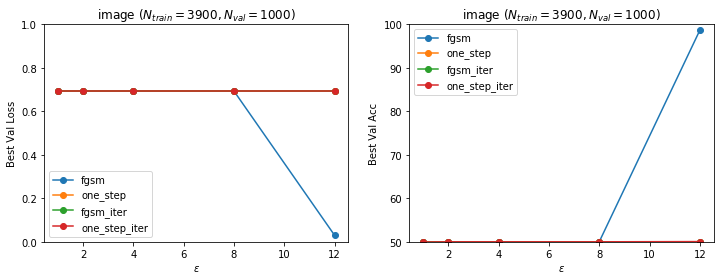

In [425]:
for i in range(len(folder_names)):
    f, ax = plt.subplots(1,2)
    f.set_size_inches(12,4)
    ax[0].plot(epsilons, np.transpose(val_losses[i]), marker='o')
    ax[0].set_ylabel('Best Val Loss')
    ax[0].set_ylim([0,1])
    ax[1].plot(epsilons, np.transpose(val_accs[i]), marker='o')
    ax[1].set_ylabel('Best Val Acc')
    ax[1].set_ylim([50,100])
    for a in ax:
        a.set_xlabel(r'$\epsilon$')
        a.legend(adv_types)
        a.set_title(r'%s ($N_{train} = 3900, N_{val} = 1000$)' % heatmap_descs[i])
    plt.show()

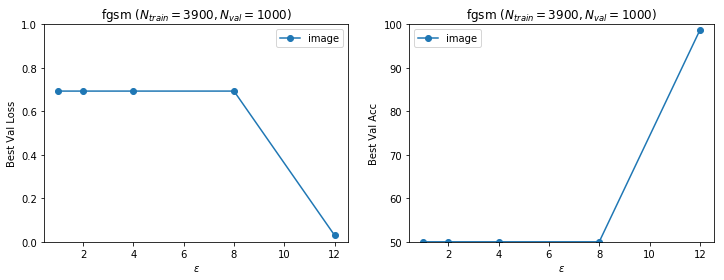

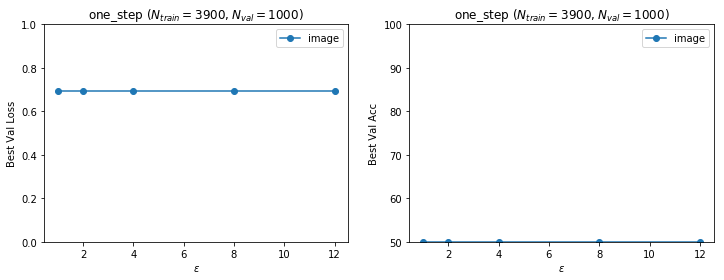

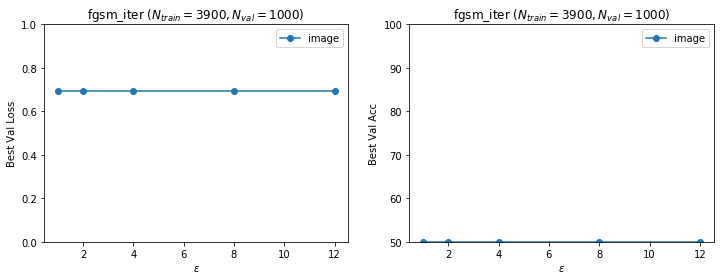

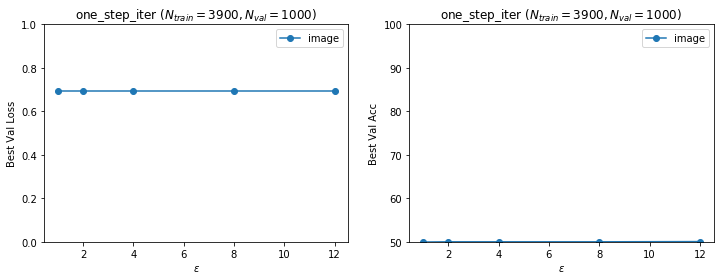

In [426]:
for j in range(len(adv_types)):
    f, ax = plt.subplots(1,2)
    f.set_size_inches(12,4)
    ax[0].plot(epsilons, np.transpose(val_losses[:,j]), marker='o')
    ax[0].set_ylabel('Best Val Loss')
    ax[0].set_ylim([0,1])
    ax[1].plot(epsilons, np.transpose(val_accs[:,j]), marker='o')
    ax[1].set_ylabel('Best Val Acc')
    ax[1].set_ylim([50,100])
    for a in ax:
        a.set_xlabel(r'$\epsilon$')
        a.legend(heatmap_descs)
        a.set_title(r'%s ($N_{train} = 3900, N_{val} = 1000$)' % adv_types[j])
    plt.show()

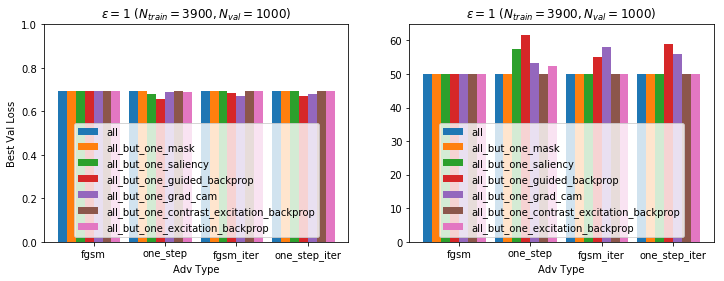

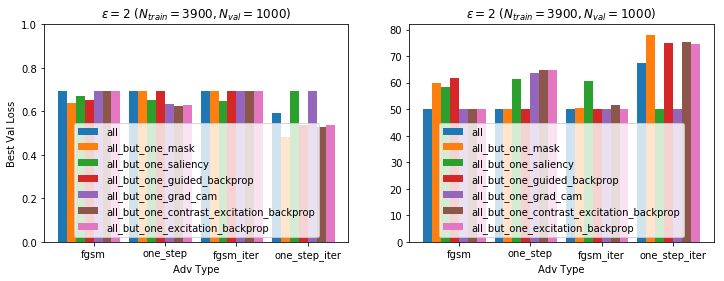

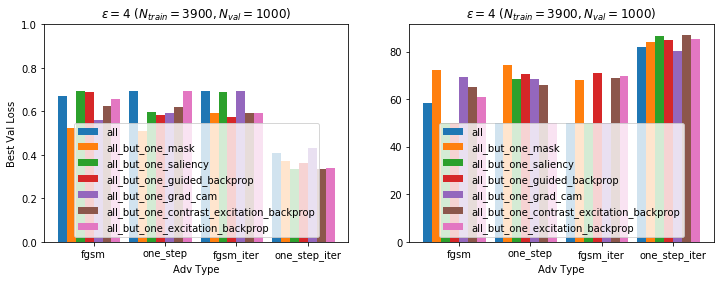

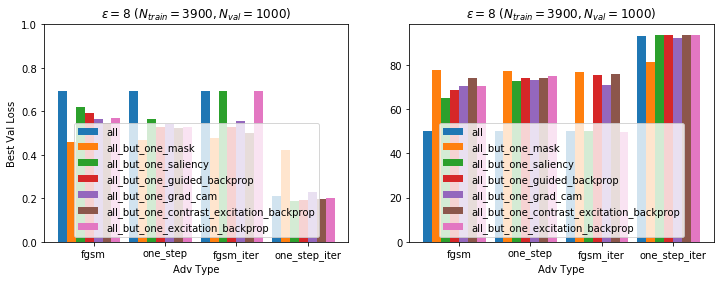

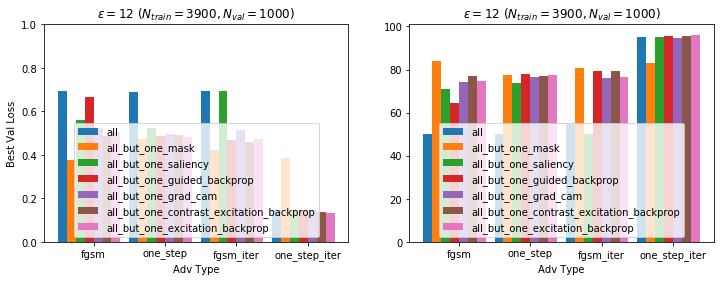

In [409]:
for k in range(len(epsilons)):
    f, ax = plt.subplots(1,2)
    f.set_size_inches(12,4)
    
    index = np.arange(len(adv_types))
    bar_width = 1./(len(folder_names)+1)
    for i in range(len(folder_names)):
        ax[0].bar(index+bar_width*i, val_losses[i,:,k], bar_width)
        ax[1].bar(index+bar_width*i, val_accs[i,:,k], bar_width)

    ax[0].set_ylabel('Best Val Loss')
    ax[0].set_ylim([0,1])
    #ax[1].set_ylabel('Best Val Acc')
    #ax[1].set_ylim([50,100])
    for a in ax:
        a.set_xlabel(r'Adv Type')
        a.set_xticks(index+bar_width*len(folder_names)/2)
        a.set_xticklabels(adv_types)
        a.legend(heatmap_descs, loc='lower center')
        a.set_title(r'$\epsilon = %d$ ($N_{train} = 3900, N_{val} = 1000$)' % epsilons[k])
    plt.show()

In [358]:
import torchvision.models as models
an = models.alexnet(pretrained=True)

In [386]:
an.state_dict().keys()

['features.0.weight',
 'features.0.bias',
 'features.3.weight',
 'features.3.bias',
 'features.6.weight',
 'features.6.bias',
 'features.8.weight',
 'features.8.bias',
 'features.10.weight',
 'features.10.bias',
 'classifier.1.weight',
 'classifier.1.bias',
 'classifier.4.weight',
 'classifier.4.bias',
 'classifier.6.weight',
 'classifier.6.bias']

In [241]:
x = torch.load('/data/ruthfong/perturb_explanations_adversarial/classifiers/best/custom_alexnet_one_step_iter_eps_8_defaults_iter_50_best.pth.tar')
x.keys()

['val_accs',
 'state_dict',
 'curr_acc',
 'curr_loss',
 'epoch',
 'best_acc',
 'best_loss',
 'val_losses',
 'trn_losses',
 'best_epoch',
 'trn_accs']

In [243]:
y = {key: value for key, value in x.items() 
             if key != 'state_dict'}
y.keys()

['val_accs',
 'curr_acc',
 'curr_loss',
 'epoch',
 'best_acc',
 'best_loss',
 'val_losses',
 'trn_losses',
 'best_epoch',
 'trn_accs']

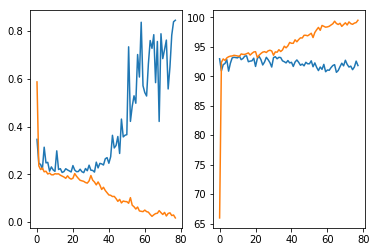

In [148]:
%matplotlib inline

f, ax = plt.subplots(1,2)
ax[0].plot(range(x['epoch']),x['val_losses'])
ax[0].plot(range(x['epoch']),x['trn_losses'])
ax[1].plot(range(x['epoch']),x['val_accs'])
ax[1].plot(range(x['epoch']),x['trn_accs'])
plt.show()

In [155]:
curr_best = np.inf
is_best = np.zeros(x['epoch'])
for i in range(x['epoch']):
    if x['val_losses'][i] < curr_best:
        curr_best = x['val_losses'][i]
        is_best[i] = 1
bests = np.where(is_best)[0]
print bests
print np.diff(bests)

[ 0  1  2  3  7 10 14 26]
[ 1  1  1  4  3  4 12]


In [201]:
adv_imgs_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_imgs/imagenet_train_heldout/one_step_iter/eps_8'
adv_masks_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_masks/imagenet_train_heldout/one_step_iter/eps_8/defaults_iter_50'

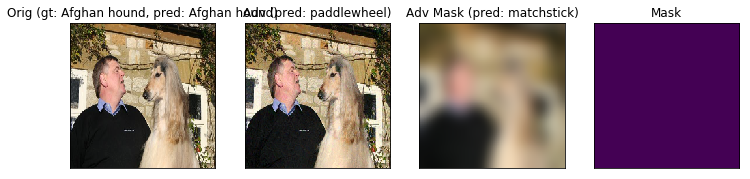

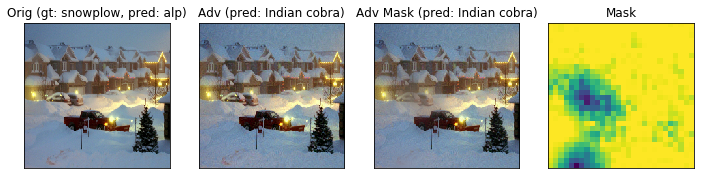

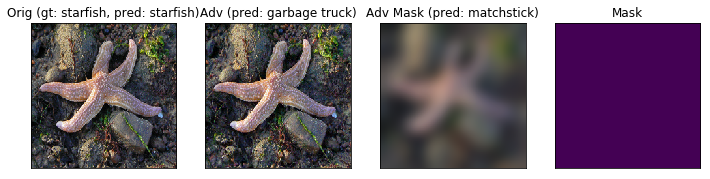

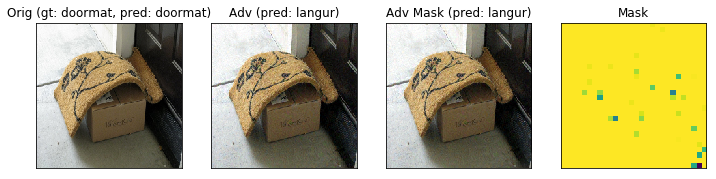

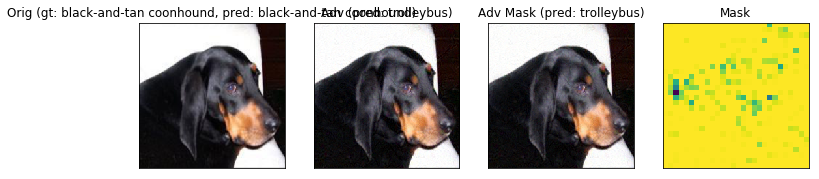

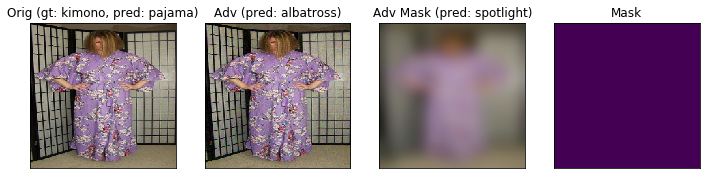

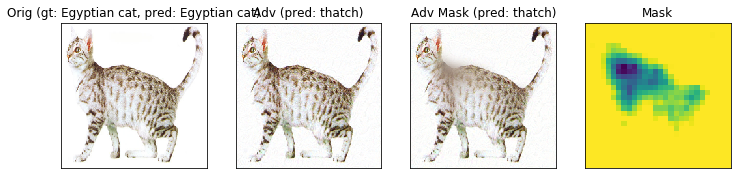

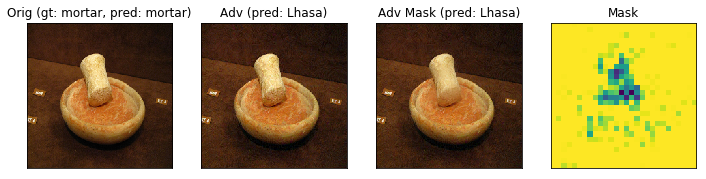

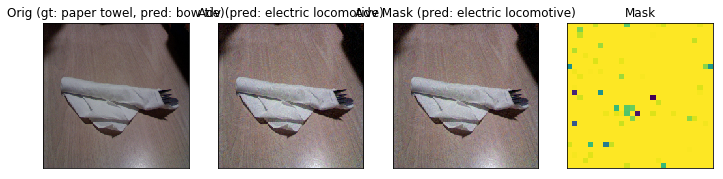

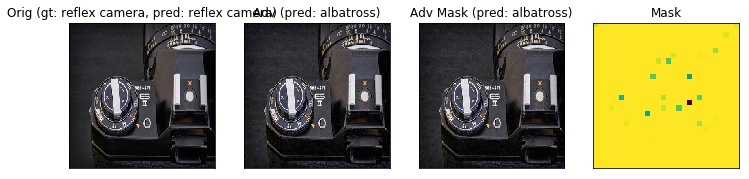

In [211]:
%matplotlib inline

from optimize_mask import blur, get_blurred_img, resize
from defaults import mask_scale, blur_mask, noise

for ind in range(100,110):
    adv_img_path = os.path.join(adv_imgs_dir, '%d.png' % ind)
    adv_mask_path = os.path.join(adv_masks_dir, '%d.png' % ind)
    adv_img = transformer.preprocess('data', caffe.io.load_image(adv_img_path))
    null_adv_img = transformer.preprocess('data', get_blurred_img(adv_img_path))
    noisy = np.random.normal(loc=0.0, scale=noise, size=mask.shape)
    adv_mask = blur(resize(np.clip(caffe.io.load_image(adv_mask_path)[:,:,0],0,1), mask_scale), blur_mask)
    adv_mask_img = transformer.deprocess('data', adv_img * adv_mask + null_adv_img * (1-adv_mask))
    adv_mask_img_path = 'adv_mask_img.png'
    imsave(adv_mask_img_path, adv_mask_img)

    max_labels = np.zeros(3, dtype='int')

    path_seqs = [paths[ind], adv_img_path, adv_mask_img_path]

    for i in range(3):    
        (max_labels[i], _, _) = check_clean_image(net, transformer, path_seqs[i], labels[ind], top = 'prob')

    f, ax = plt.subplots(1,4)
    f.set_size_inches(12,4)
    ax[0].imshow(transformer.deprocess('data', transformer.preprocess('data', caffe.io.load_image(paths[ind]))))
    ax[0].set_title('Orig (gt: %s, pred: %s)' % (get_short_class_name(labels[ind]), get_short_class_name(max_labels[0])))
    ax[1].imshow(transformer.deprocess('data', adv_img))
    ax[1].set_title('Adv (pred: %s)' % (get_short_class_name(max_labels[1])))
    ax[2].imshow(adv_mask_img)
    ax[2].set_title('Adv Mask (pred: %s)' % (get_short_class_name(max_labels[2])))
    #ax[3].imshow(adv_mask)
    ax[3].imshow(np.clip(caffe.io.load_image(adv_mask_path)[:,:,0],0,1))
    ax[3].set_title('Mask')
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

In [180]:
adv_mask.shape

(224, 224)

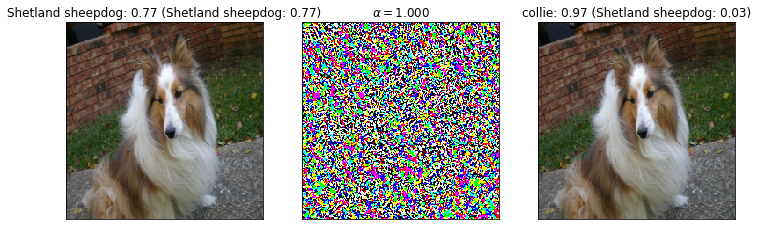

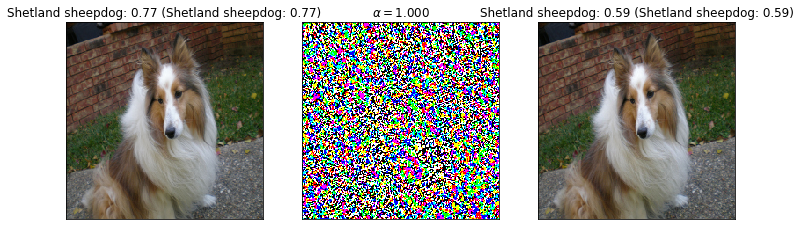

In [89]:
%matplotlib inline

alpha = 1.0
show_fig = True
i = 2
#for i in range(10):
_ = compute_adversarial_example(net, transformer, paths[i], labels[i], method = 'fgsm', 
                                alpha = alpha, show_fig = show_fig)
_ = compute_adversarial_example(net, transformer, paths[i], labels[i], method = 'one_step', 
                                alpha = alpha, show_fig = show_fig)

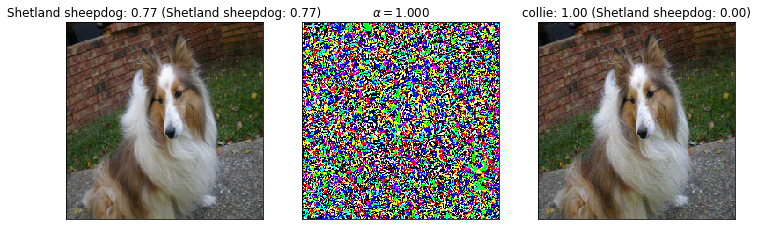

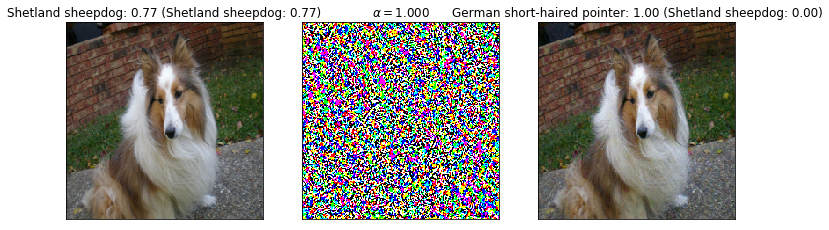

In [90]:
step = None
alpha = 1
eps = 8
show_fig = True
#for i in range(10):
i = 2
_ = compute_adversarial_example(net, transformer, paths[i], labels[i], method = 'fgsm',  
                                step = step, alpha = alpha, eps = eps, show_fig = show_fig)
_ = compute_adversarial_example_2(net, transformer, paths[i], labels[i], method = 'one_step',  
                                step = step, alpha = alpha, eps = eps, show_fig = show_fig)

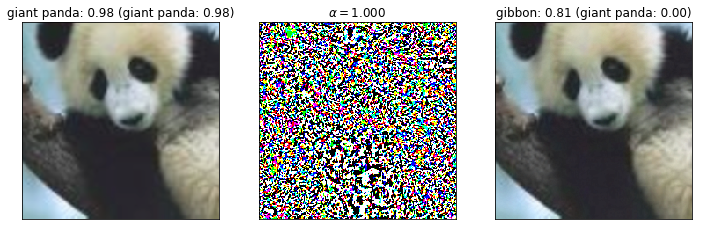

In [91]:
true_path = '../images/panda.png'
true_label = 388 # giant panda
alpha = 1.0
show_fig = True
(adv_img, adv_label, _, _) = compute_adversarial_example(net, transformer, true_path, true_label, 
                                                         method = 'fgsm', alpha = alpha, show_fig = show_fig)
adv_path = 'adv_img.png'
imsave(adv_path, adv_img)

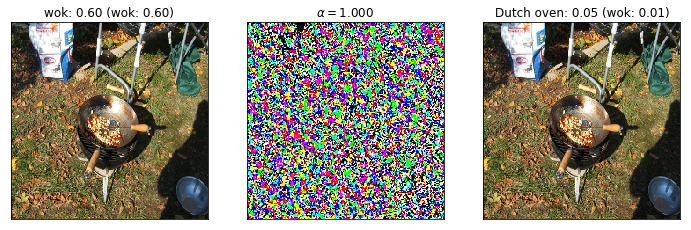

In [141]:
%matplotlib inline

#true_path = '../images/panda.png'
#true_label = 388 # giant panda
i = 1
true_path = paths[i]
true_label = labels[i]
alpha = 1
eps = 4
step = None
show_fig = True
(adv_img, adv_label, _, _) = compute_adversarial_example(net, transformer, true_path, 
                                                         true_label, method = 'one_step', 
                                                         alpha = alpha, eps = eps,
                                                         step = step, show_fig = show_fig)
adv_path = 'adv_img.png'
imsave(adv_path, adv_img)

<IPython.core.display.Javascript object>


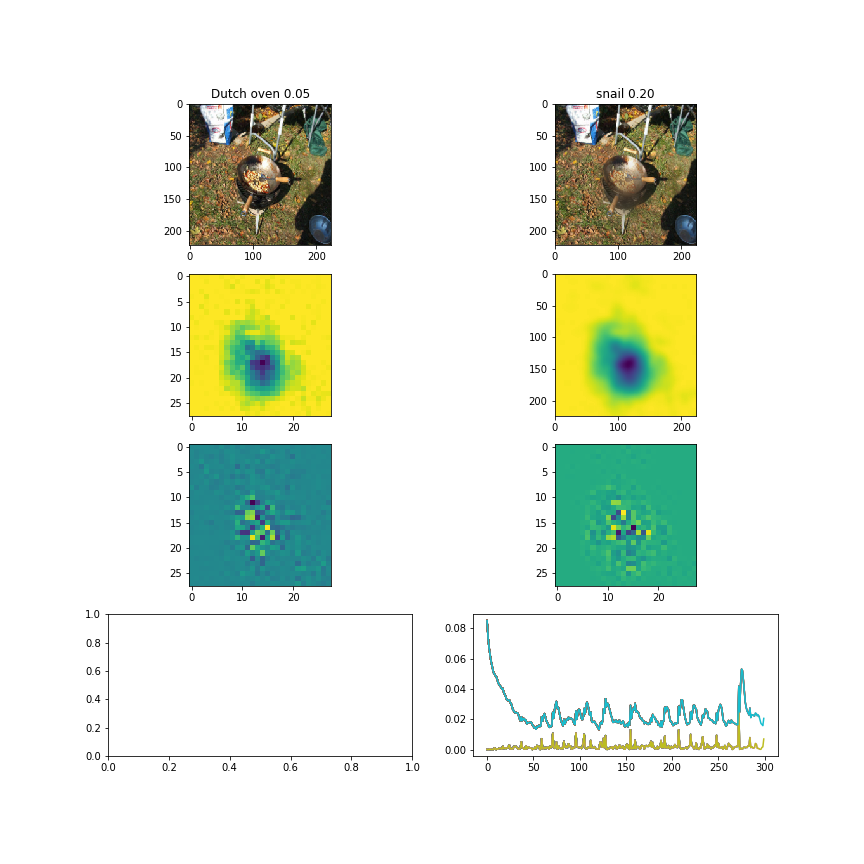

In [142]:
%matplotlib notebook

# default parameters
num_iters = 300
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 0
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

plot_step = 5
debug = False
verbose = False
mask_init_type = 'circle'
#mask_init_type = None

show_fig = True # True

adv_mask = generate_learned_mask(net, transformer, adv_path, adv_label, given_gradient = given_gradient, 
                      norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                      l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                      mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                      jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                      start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                      fig_path = None, mask_path = None, verbose = verbose, show_fig = show_fig, 
                      mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)

#true_mask = generate_learned_mask(net, transformer, true_path, true_label, given_gradient = given_gradient, 
#                      norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
#                      l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
#                      mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
#                      jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
#                      start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
#                      fig_path = None, mask_path = None, verbose = verbose, show_fig = show_fig, 
#                      mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)

In [82]:
%matplotlib inline

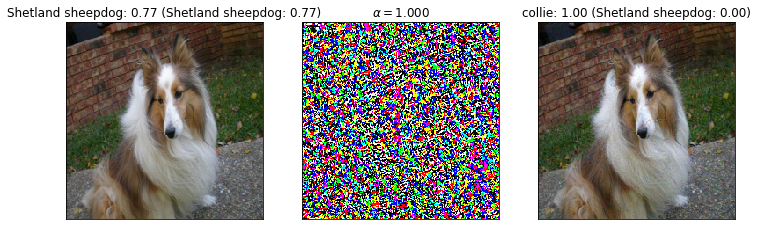

In [85]:
step = None
alpha = 1.0
eps = 8
show_fig = True
_ = compute_adversarial_example(net, transformer, true_path, true_label, method = 'fgsm', 
                                step = step, alpha = alpha, eps = eps, show_fig = show_fig)

In [52]:
epsilons = np.arange(0.01, 0.11, 0.01)[::-1]
#epsilons = np.arange(0.1, 1.1, 0.1)[::-1]
for eps in epsilons:
    noise = eps*np.sign(np.random.normal(size=adv_img.shape))
    adv_w_noise_img = adv_img + noise
    adv_path = 'adv_img_w_noise.png'
    imsave(adv_path, adv_w_noise_img)
    (max_label, top1, top5) = check_clean_image(net, transformer, adv_path, true_label, top = 'prob')
    print eps, labels_desc[max_label], top1, top5

0.1 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.09 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.08 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.07 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.06 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.05 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.04 n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca True True
0.03 n02112018 Pomeranian False True
0.02 n02113624 toy poodle False False
0.01 n02113624 toy poodle False False


In [80]:
classifier_indicator_path = '/data/ruthfong/perturb_explanations_adversarial/custom_alexnet_mask_best_val_classification_indicator.txt'
indicator = np.loadtxt(classifier_indicator_path).reshape(2,1000)
print 'clean acc: %.4f, adv acc: %.4f'% (indicator[0].sum()/float(len(indicator[0])), indicator[1].sum()/float(len(indicator[1])))

clean acc: 0.9060, adv acc: 0.6830


In [92]:
from advcleanfolder import make_dataset
heatmap_type = 'defaults'
clean_dir = '/data/ruthfong/perturb_explanations_adversarial/true_masks/imagenet_train_heldout/%s' % heatmap_type
adv_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_masks/imagenet_train_heldout/one_step_iter/eps_4/%s' % heatmap_type
imgs = make_dataset(clean_dir, adv_dir, idx = range(4000,5000))

In [110]:
indicator.shape

(2, 1000)

In [111]:
miss_clean_idx = np.where(indicator[0] == 0)[0]
miss_adv_idx = np.where(indicator[1] == 0)[0]

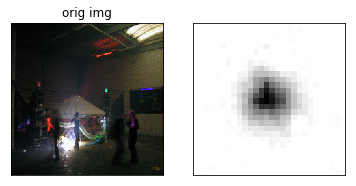

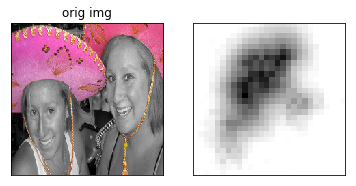

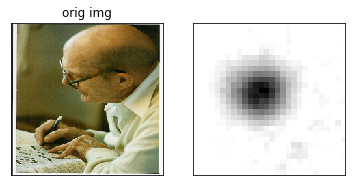

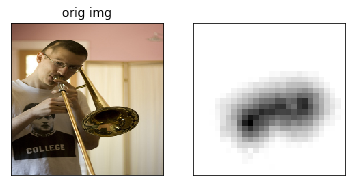

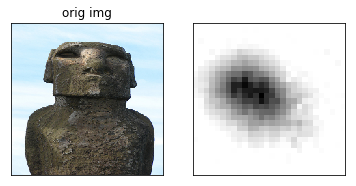

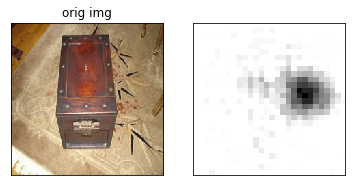

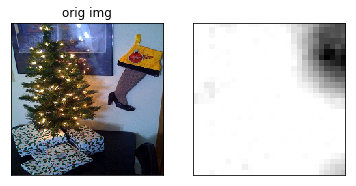

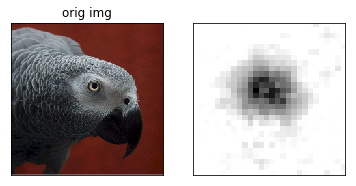

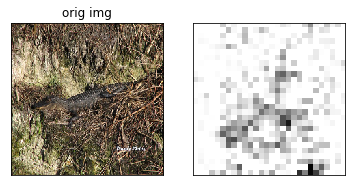

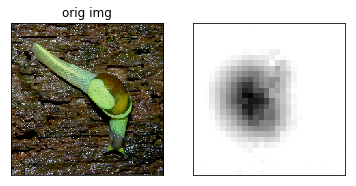

In [105]:
idx = miss_clean_idx
#idx = range(10)
for i in range(10):
    path = paths[4000+idx[i]]
    f, ax = plt.subplots(1,2)
    ax[0].imshow(transformer.deprocess('data', 
                                       transformer.preprocess('data', 
                                       caffe.io.load_image(path))))
    ax[0].set_title('orig img')
    ax[1].imshow(caffe.io.load_image(imgs[idx[i]][0]))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

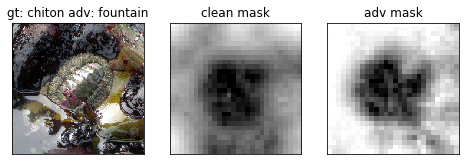

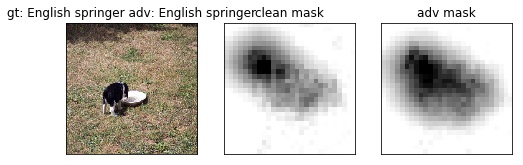

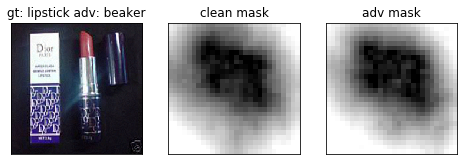

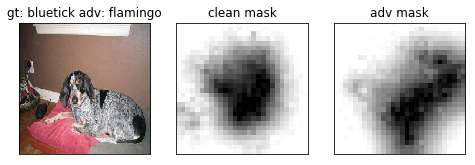

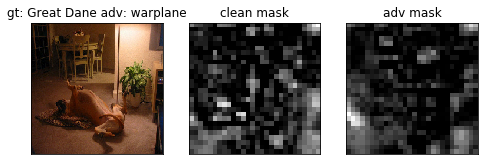

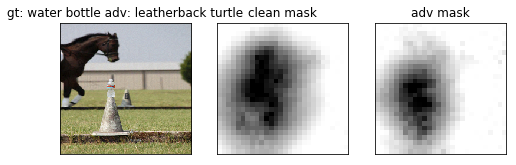

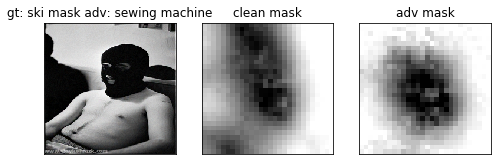

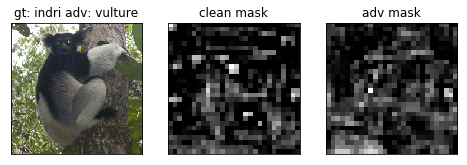

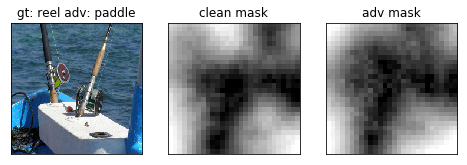

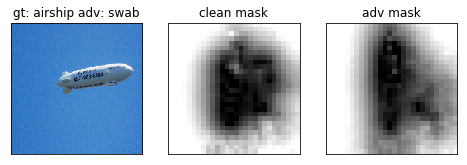

In [129]:
idx = miss_adv_idx
#idx = np.where(indicator[1] == 1)[0]
for i in range(30,40):
    path = os.path.join('/data/ruthfong/perturb_explanations_adversarial/adv_imgs/imagenet_train_heldout/one_step_iter/eps_4',
                       '%d.png' % (4000+idx[i]))
    net.blobs['data'].data[...] = transformer.preprocess('data',caffe.io.load_image(path))
    net.forward()
    adv_label = np.argmax(np.squeeze(net.blobs['prob'].data))
    #path = paths[4000+idx[i]]
    f, ax = plt.subplots(1,3)
    f.set_size_inches(8,4)
    ax[0].imshow(transformer.deprocess('data', 
                                       transformer.preprocess('data', 
                                       caffe.io.load_image(path))))
    ax[0].set_title('gt: %s adv: %s' % (get_short_class_name(labels[4000+idx[i]]), 
                                       get_short_class_name(adv_label)))
    ax[1].imshow(caffe.io.load_image(imgs[idx[i]][0]))
    ax[1].set_title('clean mask')
    ax[2].imshow(caffe.io.load_image(imgs[1000+idx[i]][0]))
    ax[2].set_title('adv mask')
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

In [14]:
def check_clean_image(net, transformer, path, label, top = 'prob'):
    img = transformer.preprocess('data', caffe.io.load_image(path))
    net.blobs['data'].data[...] = img
    net.forward(start = 'data', end = top)
    orig_scores = np.squeeze(net.blobs[top].data.copy())
    max_label = np.argmax(orig_scores)
    return (max_label, max_label == label, label in np.argsort(orig_scores)[-5:])

In [53]:
#epsilons = np.array([2,4,8,12,16,20,24,28,32,40,48,56,64,96,112,128])
epsilons = np.array([1,2,4])#8,12,16])
methods = ['clean', 'fgsm', 'one_step', 'fgsm_iter', 'one_step_iter']

top = 'prob'
show_fig = False

num_examples = 10

num_top1 = np.zeros((len(methods), len(epsilons)))
num_top5 = np.zeros((len(methods), len(epsilons)))

for i in range(num_examples):
    print i
    for j in range(len(methods)):
        m = methods[j]
        if m == 'clean':
            (adv_label, is_top1, is_top5) = check_clean_image(net, transformer, paths[i], 
                                                              labels[i], top)
            if is_top1:
                num_top1[j] += 1
            if is_top5:
                num_top5[j] += 1
            continue
        for k in range(len(epsilons)):
            e = epsilons[k]
            if 'fgsm' in m:
                method = 'fgsm'
            elif 'one_step' in m:
                method = 'one_step'
            else:
                assert(False)
                
            if 'iter' in m:    
                alpha = 1.0
                step = None
                eps = e
            else:
                alpha = e
                step = 1
                eps = None
                
            adv_label_type = 'min' # only used for one_step, g.t. label used for fgsm

            (_, adv_label, is_top1, is_top5) = compute_adversarial_example(net, transformer, 
                                                         paths[i], labels[i], 
                                                         method = method, step = step, 
                                                         alpha = alpha, eps = eps, 
                                                         adv_label = adv_label_type, 
                                                         top = top, show_fig = show_fig)
            if is_top1:
                num_top1[j][k] += 1
            if is_top5:
                num_top5[j][k] += 1
            continue


0
False 65 [62 34 49 50 58]
1
True 970 [537 796 792 970 795]
2
True 230 [226 160 169 231 230]
3
True 809 [927 659 968 969 809]
4
True 516 [750 588 516 520 431]
5
False 57 [68 54 60 67 58]
6
True 334 [361 362 364 256 334]
7
False 415 [714 443 631 852 551]
8
True 674 [333 298 674 105 106]
9
False 332 [259 154 333 338 283]


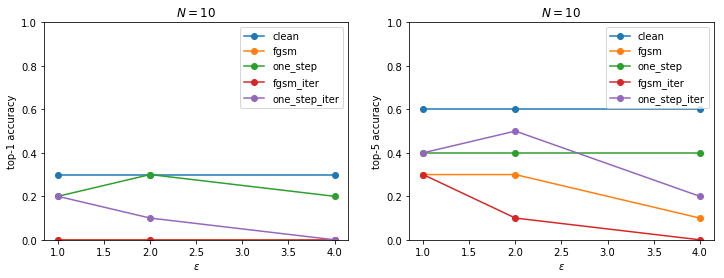

In [58]:
fig_path = 'adversarial_accuracy.png'
f, ax = plt.subplots(1,2)
f.set_size_inches(12,4)
ax[0].plot(epsilons, np.transpose(num_top1/float(num_examples)), marker='o')
ax[0].set_ylabel('top-1 accuracy')
ax[1].plot(epsilons, np.transpose(num_top5/float(num_examples)), marker='o')
ax[1].set_ylabel('top-5 accuracy')
for a in ax:
    a.set_ylim([0,1])
    a.set_xlabel(r'$\epsilon$')
    a.legend(methods)
    a.set_title(r'$N = %d$' % num_examples)
plt.savefig(fig_path)
plt.show()

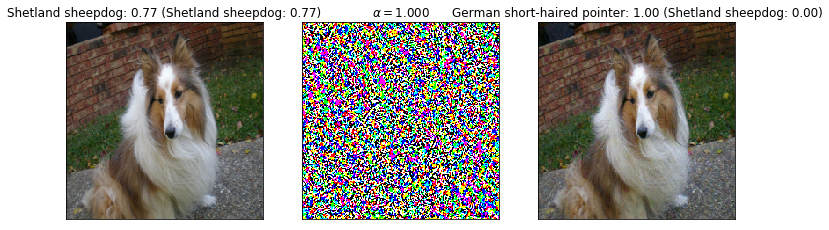

In [15]:
%matplotlib inline

ind = 2
true_path = paths[ind]
true_label = labels[ind]
alpha = 1.0
eps = 8
show_fig = True
(adv_img, adv_label, _, _) = compute_adversarial_example(net, transformer, true_path, true_label, 
                                                   method = 'one_step', step = None, alpha = alpha, 
                                                   eps = eps, show_fig = show_fig)

In [16]:
adv_path = 'adv_img.png'
imsave(adv_path, adv_img)

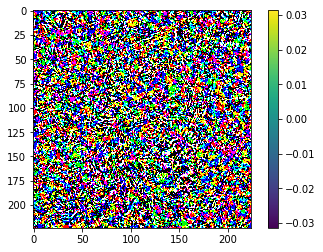

In [17]:
f, ax = plt.subplots(1,1)
fax = ax.imshow(adv_img - transformer.deprocess('data', transformer.preprocess('data', caffe.io.load_image(true_path))))
f.colorbar(fax)
plt.show()

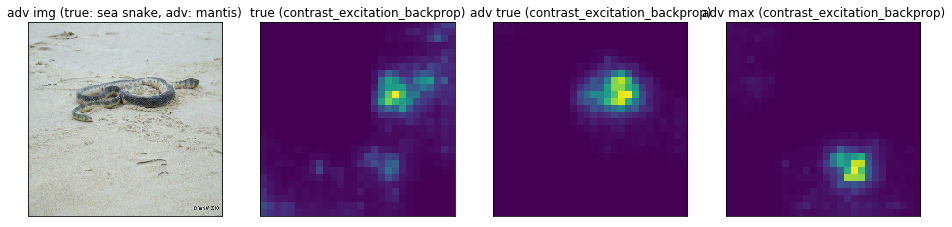

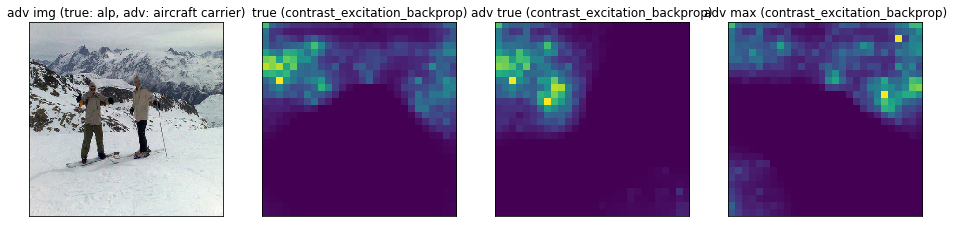

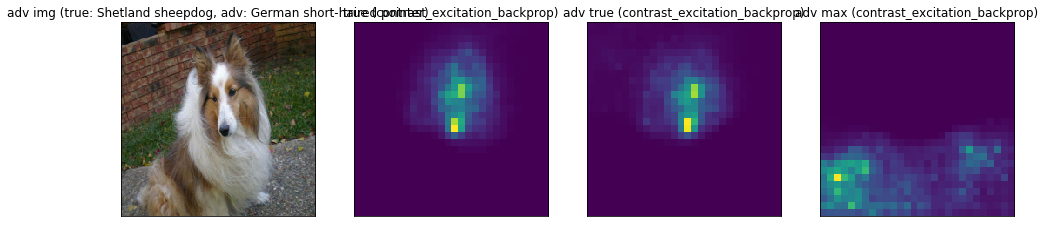

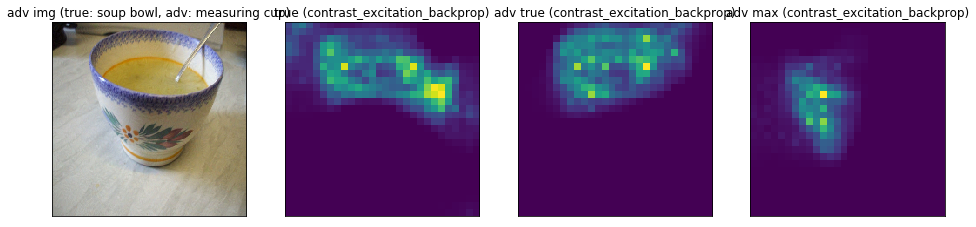

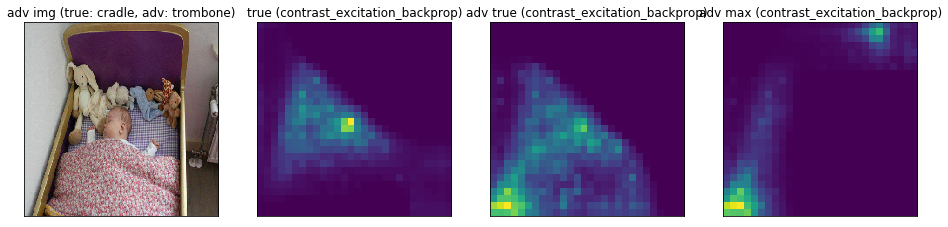

In [9]:
heatmap_type = 'contrast_excitation_backprop'

top = 'loss3/classifier'
if heatmap_type == 'saliency' or heatmap_type == 'guided_backprop':
    bottom = 'data'
    norm_deg = np.inf
elif heatmap_type == 'excitation_backprop':
    bottom = 'pool2/3x3_s2'
    norm_deg = -1
elif heatmap_type == 'contrast_excitation_backprop':
    bottom = 'pool2/3x3_s2'
    norm_deg = -2
elif heatmap_type == 'grad_cam':
    bottom = 'inception_5b/output'
    norm_deg = None

adv_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_imgs/imagenet_val/one_step_iter/eps_4/'

for ind in range(5):
    true_label = labels[ind]
    true_path = paths[ind]
    adv_path = os.path.join(adv_dir, '%d.png' % ind)

    # compute adversarial label
    adv_img = transformer.preprocess('data', caffe.io.load_image(adv_path))
    net.blobs['data'].data[...] = adv_img
    net.forward()
    scores = np.squeeze(net.blobs['prob'].data)
    adv_label = np.argmax(scores)

    orig_heatmap = compute_heatmap(net, transformer, true_path, true_label, heatmap_type, top, top,
                        outputBlobName = bottom, outputLayerName = bottom, secondTopBlobName = 'pool5/7x7_s1',
                        secondTopLayerName = 'pool5/7x7_s1', norm_deg = norm_deg, gpu = gpu)
    adv_true_heatmap = compute_heatmap(net, transformer, adv_path, true_label, heatmap_type, top, top,
                        outputBlobName = bottom, outputLayerName = bottom, secondTopBlobName = 'pool5/7x7_s1',
                        secondTopLayerName = 'pool5/7x7_s1', norm_deg = norm_deg, gpu = gpu)
    adv_max_heatmap = compute_heatmap(net, transformer, adv_path, adv_label, heatmap_type, top, top,
                        outputBlobName = bottom, outputLayerName = bottom, secondTopBlobName = 'pool5/7x7_s1',
                        secondTopLayerName = 'pool5/7x7_s1', norm_deg = norm_deg, gpu = gpu)

    # save comparison figures for first 100
    if ind < 100:
        f, ax = plt.subplots(1,4)
        f.set_size_inches(16,4)
        ax[0].imshow(caffe.io.load_image(adv_path))
        ax[0].set_title('adv img (true: %s, adv: %s)' % (get_short_class_name(true_label), 
                                                        get_short_class_name(adv_label)))
        ax[1].imshow(orig_heatmap)
        ax[1].set_title('true (%s)' % heatmap_type)
        ax[2].imshow(adv_true_heatmap)
        ax[2].set_title('adv true (%s)' % heatmap_type)
        ax[3].imshow(adv_max_heatmap)
        ax[3].set_title('adv max (%s)' % heatmap_type)
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        #plt.savefig(fig_path)
        plt.show()
    
    # save saliency masks
    #imsave(os.path.join(adv_mask_dir, '%d.png' % ind), adv_mask)
    #imsave(os.path.join(true_mask_dir, '%d.png' % ind), true_mask)

In [21]:
%matplotlib notebook

# default parameters
num_iters = 50
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 0
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

plot_step = 10
debug = False
verbose = False
mask_init_type = 'circle'
#mask_init_type = None

show_fig = True # True

# compute adversarial label
adv_img = transformer.preprocess('data', caffe.io.load_image(adv_path))
net.blobs['data'].data[...] = adv_img
net.forward()
scores = np.squeeze(net.blobs['prob'].data)
adv_label = np.argmax(scores)

adv_mask = generate_learned_mask(net, transformer, adv_path, adv_label, given_gradient = given_gradient, 
                      norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                      l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                      mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                      jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                      start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                      fig_path = None, mask_path = None, verbose = verbose, show_fig = show_fig, 
                      mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)

true_mask = generate_learned_mask(net, transformer, true_path, true_label, given_gradient = given_gradient, 
                      norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                      l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                      mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                      jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                      start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                      fig_path = None, mask_path = None, verbose = verbose, show_fig = show_fig, 
                      mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)

fig_path = None
mask_path = None

%matplotlib inline
# save comparison figures for first 100
f, ax = plt.subplots(1,3)
f.set_size_inches(12,4)
ax[0].imshow(caffe.io.load_image(adv_path))
ax[0].set_title('adv img (true: %s, adv: %s)' % (get_short_class_name(true_label), 
                                                get_short_class_name(adv_label)))
ax[1].imshow(true_mask)
ax[1].set_title('true mask (defaults, iters = %d)' % num_iters)
ax[2].imshow(adv_mask)
ax[2].set_title('adv mask (defaults, iters = %d)' % num_iters)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

UnboundLocalError: local variable 'ax' referenced before assignment

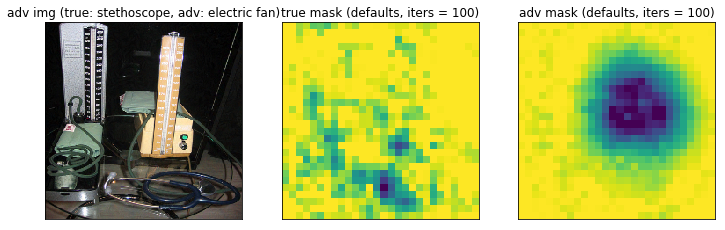

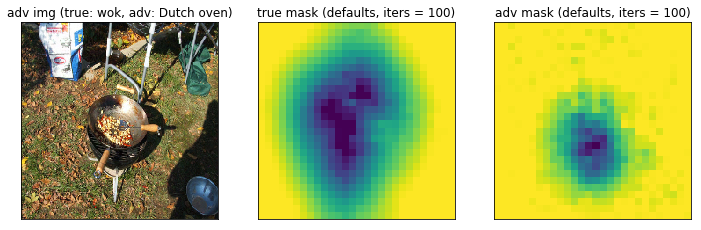

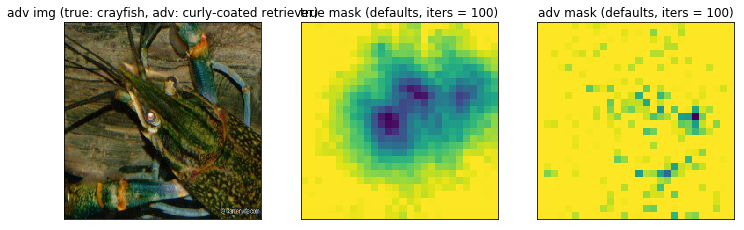

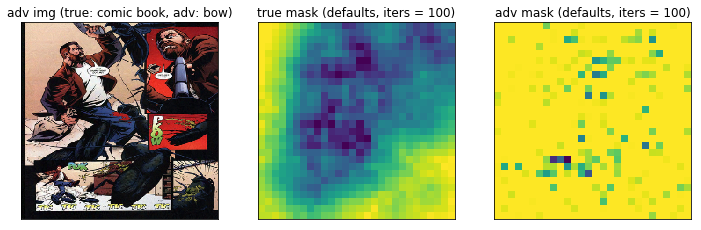

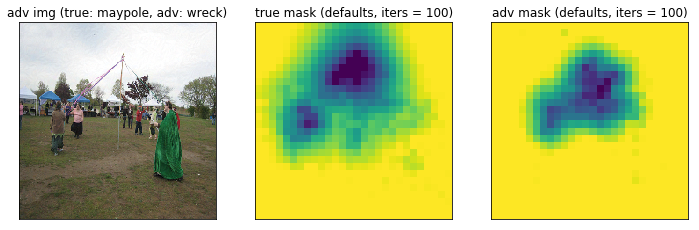

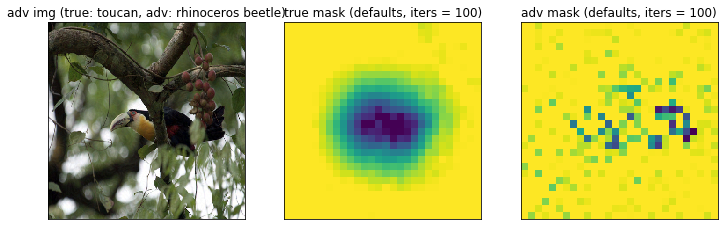

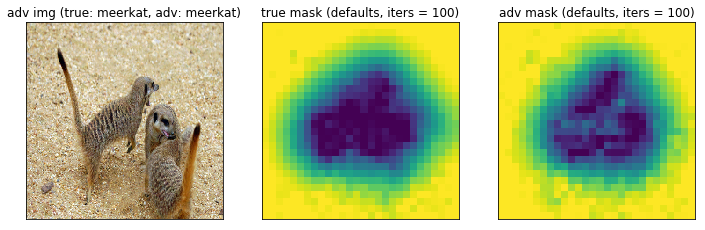

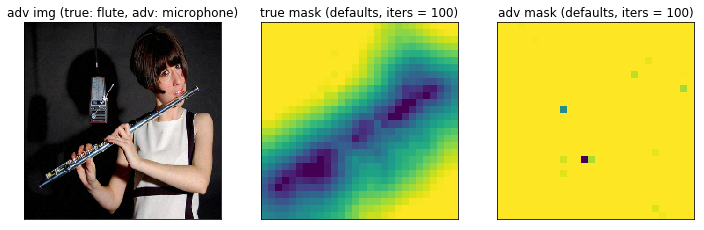

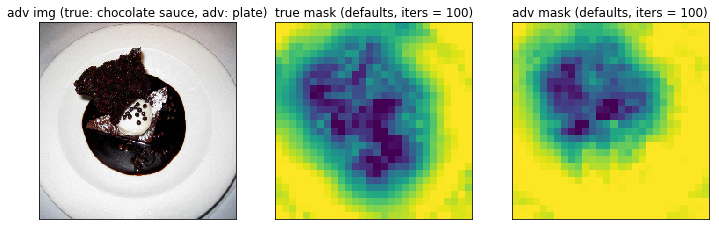

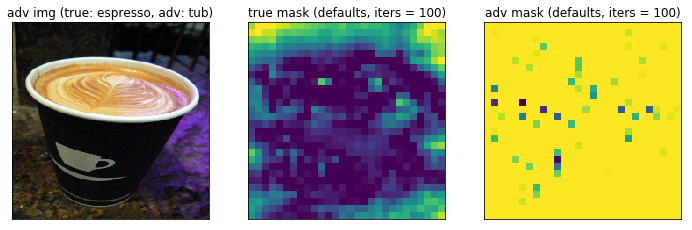

In [131]:
%matplotlib inline

# default parameters
num_iters = 100
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 0
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

plot_step = None # 10
debug = False
verbose = False
mask_init_type = 'circle'
#mask_init_type = None

show_fig = False # True

adv_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_imgs/imagenet_train_heldout/one_step_iter/eps_4'
#adv_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_imgs/imagenet_val/one_step_iter/eps_4/'

for ind in range(10):
    true_label = labels[ind]
    true_path = paths[ind]
    adv_path = os.path.join(adv_dir, '%d.png' % ind)

    # compute adversarial label
    adv_img = transformer.preprocess('data', caffe.io.load_image(adv_path))
    net.blobs['data'].data[...] = adv_img
    net.forward()
    scores = np.squeeze(net.blobs['prob'].data)
    adv_label = np.argmax(scores)

    adv_mask = generate_learned_mask(net, transformer, adv_path, adv_label, given_gradient = given_gradient, 
                          norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                          l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                          mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                          jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                          start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                          fig_path = None, mask_path = None, verbose = verbose, show_fig = show_fig, 
                          mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)

    true_mask = generate_learned_mask(net, transformer, true_path, true_label, given_gradient = given_gradient, 
                          norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                          l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                          mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                          jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                          start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                          fig_path = None, mask_path = None, verbose = verbose, show_fig = show_fig, 
                          mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)

    fig_path = None
    mask_path = None

    # save comparison figures for first 100
    if ind < 100:
        f, ax = plt.subplots(1,3)
        f.set_size_inches(12,4)
        ax[0].imshow(caffe.io.load_image(adv_path))
        ax[0].set_title('adv img (true: %s, adv: %s)' % (get_short_class_name(true_label), 
                                                        get_short_class_name(adv_label)))
        ax[1].imshow(true_mask)
        ax[1].set_title('true mask (defaults, iters = %d)' % num_iters)
        ax[2].imshow(adv_mask)
        ax[2].set_title('adv mask (defaults, iters = %d)' % num_iters)
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        #plt.savefig(fig_path)
        plt.show()
    
    # save saliency masks
    #imsave(os.path.join(adv_mask_dir, '%d.png' % ind), adv_mask)
    #imsave(os.path.join(true_mask_dir, '%d.png' % ind), true_mask)


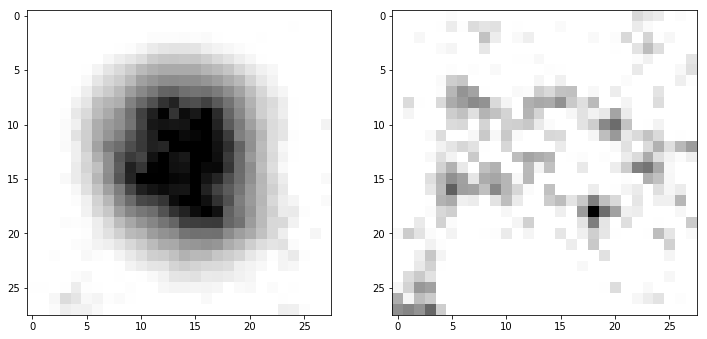

In [86]:
imsave('adv_mask.png', adv_mask)
imsave('true_mask.png', true_mask)

f, ax = plt.subplots(1,2)
ax[0].imshow(caffe.io.load_image('true_mask.png'))
ax[1].imshow(caffe.io.load_image('adv_mask.png'))
plt.show()

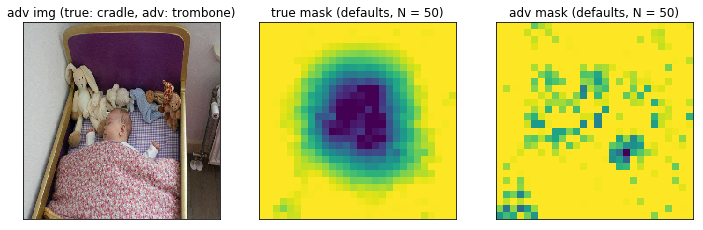

In [84]:
%matplotlib inline
f, ax = plt.subplots(1,3)
f.set_size_inches(12,4)
ax[0].imshow(caffe.io.load_image(adv_path))
ax[0].set_title('adv img (true: %s, adv: %s)' % (get_short_class_name(true_label), 
                                                get_short_class_name(adv_label)))
ax[1].imshow(true_mask)
ax[1].set_title('true mask (defaults, N = %d)' % num_iters)
ax[2].imshow(adv_mask)
ax[2].set_title('adv mask (defaults, N = %d)' % num_iters)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

0.999998


<IPython.core.display.Javascript object>


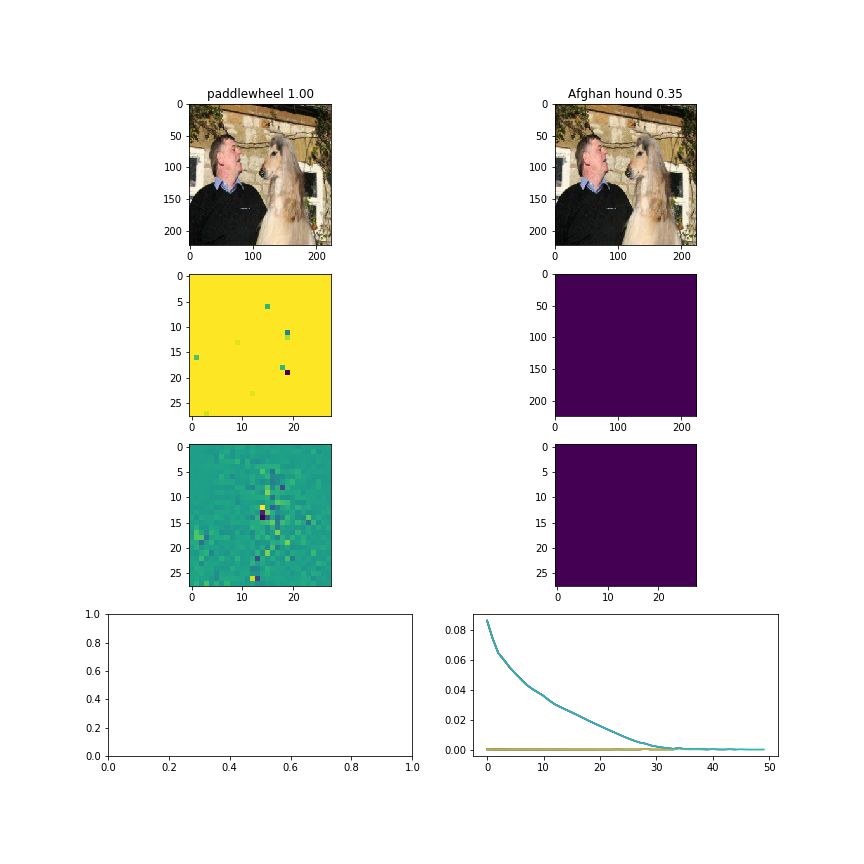

In [344]:
%matplotlib notebook

# default parameters
num_iters = 51
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 0
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

plot_step = 5
debug = False
verbose = False
mask_init_type = 'circle'
#mask_init_type = None

show_fig = True

adv_imgs_dir = '/data/ruthfong/perturb_explanations_adversarial/adv_imgs/imagenet_train_heldout/one_step_iter/eps_12'

#path = 'adv_img.png'
ind = 100
path = os.path.join(adv_imgs_dir, '%d.png' % ind)
(label, _, _) = check_clean_image(net, transformer, path, labels[ind], top = 'prob')

img = transformer.preprocess('data', caffe.io.load_image(path))
net.blobs['data'].data[...] = img
net.forward()
scores = np.squeeze(net.blobs['prob'].data)
print scores[label]
sorted_idx = np.argsort(scores)
if given_gradient:
    target = np.zeros(scores.shape)
    target[sorted_idx[:-(num_top+1):-1]] = 1
else:
    target = sorted_idx[:-(num_top+1):-1]

fig_path = None
mask_path = None

mask = generate_learned_mask(net, transformer, path, label, given_gradient = given_gradient, 
                      norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                      l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                      mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                      jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                      start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                      fig_path = fig_path, mask_path = mask_path, verbose = verbose, show_fig = show_fig, 
                      mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)


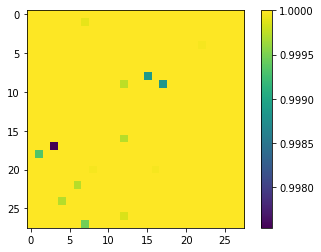

In [345]:
%matplotlib inline
f, ax = plt.subplots(1,1)
cax = ax.imshow(mask)
f.colorbar(cax)
plt.show()

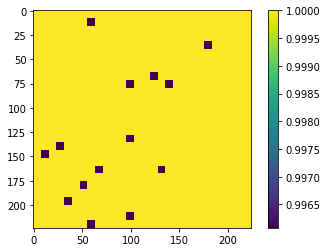

paddlewheel


TypeError: Invalid dimensions for image data

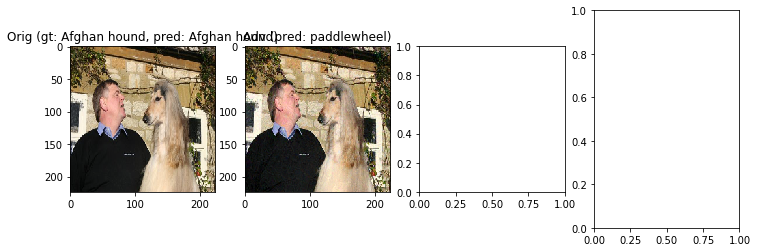

In [346]:
%matplotlib inline

adv_img_path = os.path.join(adv_imgs_dir, '%d.png' % ind)
adv_mask_path = os.path.join(adv_masks_dir, '%d.png' % ind)
adv_img = transformer.preprocess('data', caffe.io.load_image(adv_img_path))
null_adv_img = transformer.preprocess('data', get_blurred_img(adv_img_path))
#noisy = np.random.normal(loc=0.0, scale=noise, size=mask.shape)
#fake_mask = np.reshape(np.random.binomial(n=np.prod(mask.shape), p=(1-0.00019)), mask.shape)
#adv_mask = blur(resize(np.clip(caffe.io.load_image(adv_mask_path)[:,:,0],0,1), mask_scale), blur_mask)
adv_mask = blur(resize(np.clip(mask,0,1), mask_scale), blur_mask)
f, ax = plt.subplots(1,1)
cax = ax.imshow(adv_mask)
f.colorbar(cax)
plt.show()
adv_mask_img = adv_img * adv_mask + null_adv_img * (1-adv_mask)
adv_mask_img_path = 'adv_mask_img.png'
imsave(adv_mask_img_path, transformer.deprocess('data',adv_mask_img))

top = 'prob'
net.blobs['data'].data[...] = adv_mask_img
net.forward(start = 'data', end = top)
orig_scores = np.squeeze(net.blobs[top].data.copy())
max_label = np.argmax(orig_scores)

print get_short_class_name(max_label)
max_labels = np.zeros(3, dtype='int')

path_seqs = [paths[ind], adv_img_path, adv_mask_img_path]

for i in range(3):    
    (max_labels[i], _, _) = check_clean_image(net, transformer, path_seqs[i], labels[ind], top = 'prob')

f, ax = plt.subplots(1,4)
f.set_size_inches(12,4)
ax[0].imshow(transformer.deprocess('data', transformer.preprocess('data', caffe.io.load_image(paths[ind]))))
ax[0].set_title('Orig (gt: %s, pred: %s)' % (get_short_class_name(labels[ind]), get_short_class_name(max_labels[0])))
ax[1].imshow(transformer.deprocess('data', adv_img))
ax[1].set_title('Adv (pred: %s)' % (get_short_class_name(max_labels[1])))
ax[2].imshow(adv_mask_img)
ax[2].set_title('Adv Mask (pred: %s)' % (get_short_class_name(max_labels[2])))
#ax[3].imshow(adv_mask)
ax[3].imshow(adv_mask)
ax[3].set_title('Mask')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

0.771916


<IPython.core.display.Javascript object>


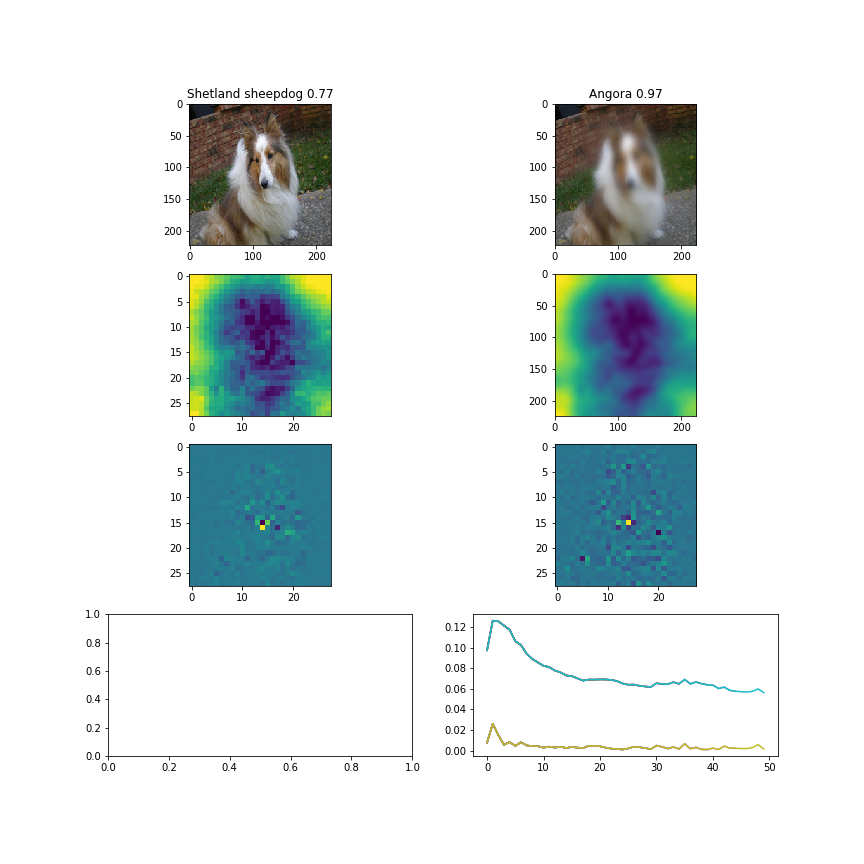

In [72]:
%matplotlib notebook

# default parameters
num_iters = 50
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 0
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

plot_step = 5
debug = False
verbose = False
mask_init_type = 'circle'
#mask_init_type = None

show_fig = True

path = paths[2] # 'adv_img.png'
label = labels[2] # true_label
img = transformer.preprocess('data', caffe.io.load_image(path))
net.blobs['data'].data[...] = img
net.forward()
scores = np.squeeze(net.blobs['prob'].data)
print scores[label]
sorted_idx = np.argsort(scores)

fig_path = None
mask_path = None

mask = generate_learned_mask(net, transformer, path, label, given_gradient = given_gradient, 
                      norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                      l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                      mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                      jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                      start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                      fig_path = fig_path, mask_path = mask_path, verbose = verbose, show_fig = show_fig, 
                      mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)
